### 진행 예정 중인 단계

1. BaseLine : 기본적으로 변동 없는 센서 컬럼 제거
2. RUL Clipping : RUL 상한치를 몇으로 할 지 최적 조건 탐색
3. 스케일링 기법 적용 - StandardScaler, MinMaxScaler, RobustScaler 등
4. Low-Pass_Filter 적용 - 센서 데이터 노이즈 스무딩
5. 특징 공학 (Feature Engineering) - 새로운 피처 생성
6. Grid Search, Random Search, Bayesian Optimization 등을 통한 하이퍼파라미터 튜닝 및 GroupKFold 교차검증

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# 한글 인코딩 문제 해결
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
train1 = pd.read_csv(r'C:\Users\ASUS\.cache\kagglehub\datasets\behrad3d\nasa-cmaps\versions\1\CMaps\train_FD001.txt', sep=' ', header=None)
test1 = pd.read_csv(r'C:\Users\ASUS\.cache\kagglehub\datasets\behrad3d\nasa-cmaps\versions\1\CMaps\test_FD001.txt', sep=' ', header=None)
RUL1 = pd.read_csv(r'C:\Users\ASUS\.cache\kagglehub\datasets\behrad3d\nasa-cmaps\versions\1\CMaps\RUL_FD001.txt', sep=' ', header=None)
train1.drop(columns=[26, 27], inplace=True)
test1.drop(columns=[26, 27], inplace=True)
RUL1.drop(columns=[1], inplace=True)

col_names = ['unit', 'cycle', 'setting_1', 'setting_2', 'setting_3', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
train1.columns = col_names
test1.columns = col_names
RUL1.columns = ['RUL']

In [12]:
# RUL 구하기
def get_RUL(df):
    rul_list = [x for x in df.groupby('unit')['cycle'].max()]
    for unit in df['unit'].unique():
        df.loc[df['unit']==unit, 'RUL'] = rul_list[unit-1] - df.loc[df['unit']==unit, 'cycle']

get_RUL(train1)

In [13]:
train1

,unit,cycle,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191.0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190.0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189.0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188.0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4.0
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3.0
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2.0
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1.0


---

- 전처리 1 : 제외할 만한 변동이 없는 컬럼 찾기

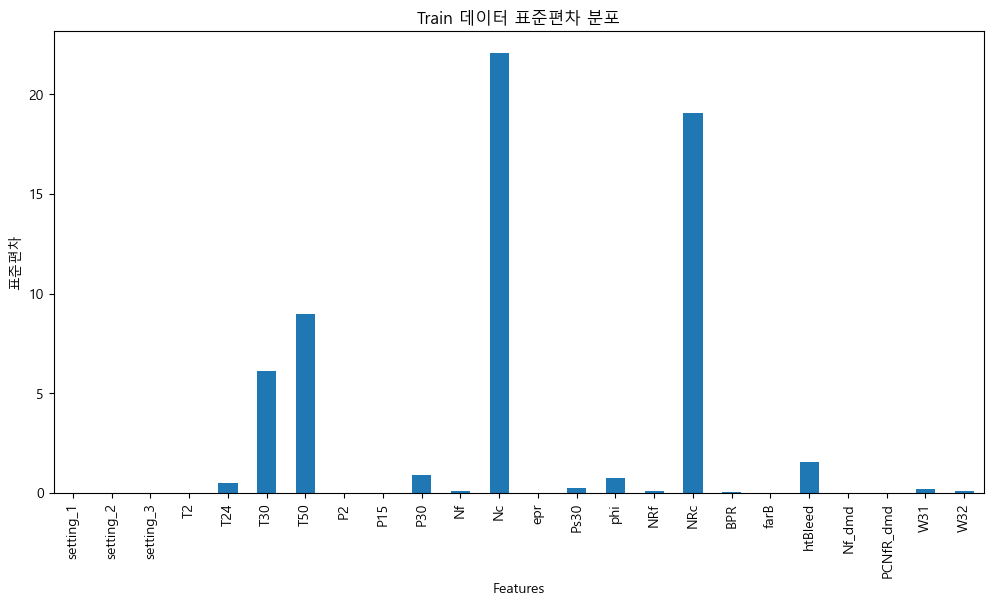

In [18]:
# 표준편차 분포로 제외할 만한 컬럼 찾기
plt.figure(figsize=(12,6))
std = train1.drop(columns=['unit', 'cycle', 'RUL']).std()
std.plot(kind='bar')
plt.title('Train 데이터 표준편차 분포')
plt.xlabel('Features')
plt.ylabel('표준편차')
plt.show()

In [31]:
# 변동 없는 컬럼 제외하기로 한다면 setting_1, 2, 3, T2, P2, P15, epr, farB, Nf_dmd, PCNfR_dmd 제거하기
features = ['cycle', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']

---

1. 베이스라인

- 모델 적용해보기 (Random Forest)

In [37]:
X_train

,cycle,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32
0,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [108]:
test1.loc[test1['unit'].isin(test1['unit'].unique())].groupby('unit').last()[features].reset_index().drop(columns=['unit'])

,cycle,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32
0,31,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552
1,49,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618
2,126,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740
3,106,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581
4,98,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,97,642.30,1590.88,1397.94,553.99,2388.03,9062.41,47.14,522.30,2388.01,8148.24,8.4110,391,38.96,23.4606
96,134,642.59,1582.96,1410.92,554.05,2388.06,9076.36,47.38,521.58,2388.06,8155.48,8.4500,395,38.61,23.2953
97,121,642.68,1599.51,1415.47,553.44,2388.13,9062.34,47.66,521.53,2388.09,8146.39,8.4235,394,38.76,23.3608
98,97,642.00,1585.03,1397.98,554.75,2388.01,9067.16,47.26,521.82,2388.02,8150.38,8.4003,391,38.95,23.3595


In [ ]:
# random_state르 지정하지 않고 교차검증 법을 사용하여 모델을 평가
# 그룹 KFold를 사용하여 단위별로 데이터를 나누기
from sklearn.model_selection import GroupKFold
# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV
# RandomSearchCV도 사용하여 하이퍼파라미터 튜닝

X1_train = train1[features]
y1_train = train1['RUL']

# 시계열성을 신경쓰지 않으므로 각 테스트의 최초 사이클만 대입
X_test = test1.loc[test1['unit'].isin(test1['unit'].unique())].groupby('unit').last()[features].reset_index().drop(columns=['unit'])
y_test = RUL1['RUL']
group = train1['unit']

rf1 = RandomForestRegressor(random_state=42)
rf1.fit(X1_train, y1_train)

RandomForestRegressor(random_state=42)

In [42]:
rf1_pred = rf1.predict(X_test)

rf1_mse = mean_squared_error(y_test, rf1_pred)
rf1_rmse = np.sqrt(rf1_mse)
rf1_mae = np.mean(np.abs(y_test - rf1_pred))

print(f'Random Forest Regressor 성능:')
print(f'MSE: {rf1_mse:.4f}')
print(f'RMSE: {rf1_rmse:.4f}')
print(f'MAE: {rf1_mae:.4f}')

Random Forest Regressor 성능:
MSE: 727.2402
RMSE: 26.9674
MAE: 20.2648


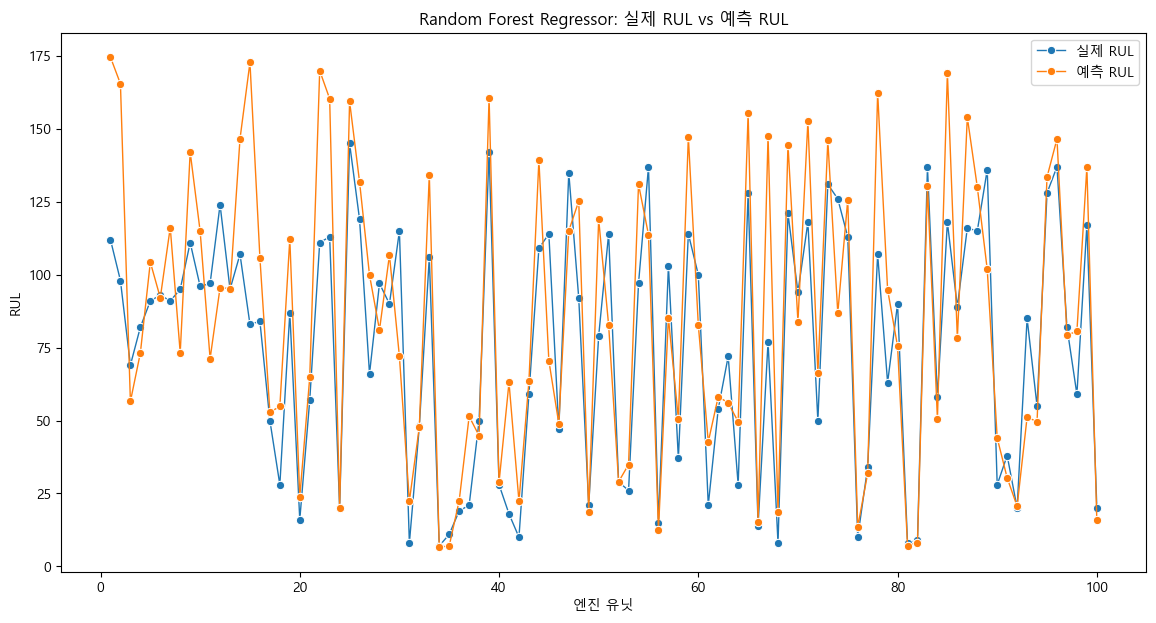

In [61]:
# 결과 시각화
plt.figure(figsize=(14, 7))
sns.lineplot(x=np.arange(1, len(y_test)+1), y=y_test, label='실제 RUL', marker='o', linewidth=1)
sns.lineplot(x=np.arange(1, len(rf1_pred)+1), y=rf1_pred, label='예측 RUL', marker='o', linewidth=1)
plt.title('Random Forest Regressor: 실제 RUL vs 예측 RUL')
plt.xlabel('엔진 유닛')
plt.ylabel('RUL')
plt.legend()
plt.show()

---

1. RUL Clipping

In [64]:
# RUL의 상한치 정하기
def clip_RUL(rul, max_rul=125):
    return np.minimum(rul, max_rul)
# trian셋에 RUL 클리핑 적용
train1['RUL'] = clip_RUL(train1['RUL'], max_rul=125)
train1

,unit,cycle,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,125.0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,125.0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,125.0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,125.0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4.0
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3.0
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2.0
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1.0


In [66]:
X2_train = train1[features]
y2_train = train1['RUL']

# 시계열성을 신경쓰지 않으므로 각 테스트의 최초 사이클만 대입
X_test = test1.loc[test1['unit'].isin(test1['unit'].unique())].groupby('unit').last()[features].reset_index().drop(columns=['unit'])
y_test = RUL1['RUL']
group = train1['unit']

rf2 = RandomForestRegressor(random_state=42)
rf2.fit(X2_train, y2_train)

RandomForestRegressor(random_state=42)

In [67]:
rf2_pred = rf2.predict(X_test)

rf2_mse = mean_squared_error(y_test, rf2_pred)
rf2_rmse = np.sqrt(rf2_mse)
rf2_mae = np.mean(np.abs(y_test - rf2_pred))
print(f'Random Forest Regressor 성능:')
print(f'MSE: {rf2_mse:.4f}')
print(f'RMSE: {rf2_rmse:.4f}')
print(f'MAE: {rf2_mae:.4f}')

Random Forest Regressor 성능:
MSE: 325.3480
RMSE: 18.0374
MAE: 13.3536


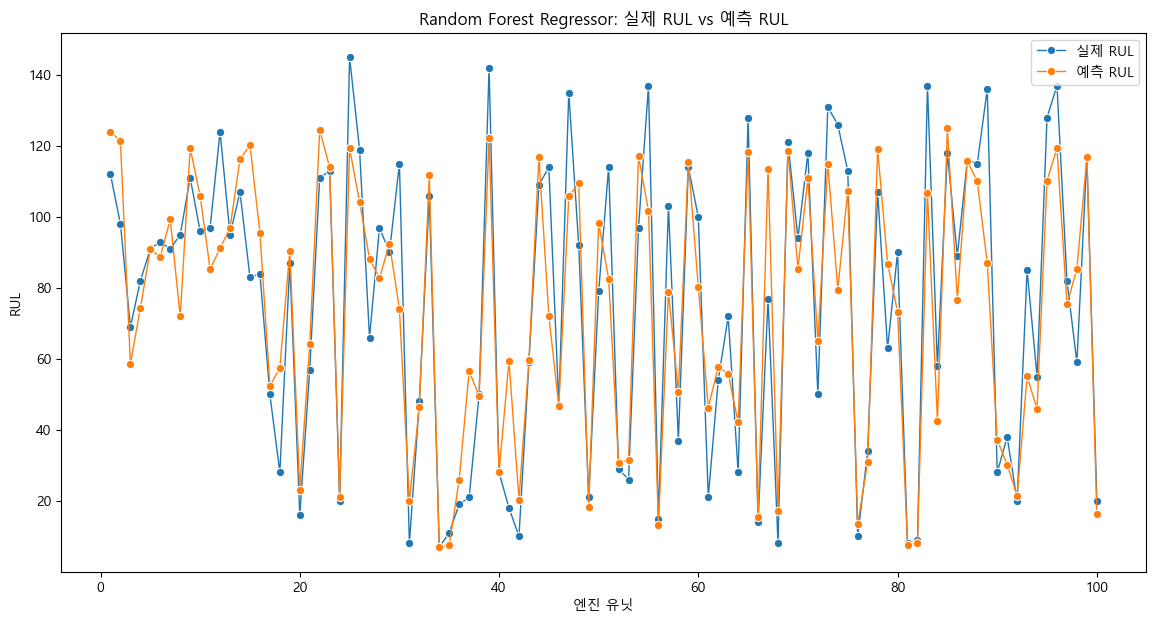

In [69]:
# 결과 시각화
plt.figure(figsize=(14, 7))
sns.lineplot(x=np.arange(1, len(y_test)+1), y=y_test, label='실제 RUL', marker='o', linewidth=1)
sns.lineplot(x=np.arange(1, len(rf2_pred)+1), y=rf2_pred, label='예측 RUL', marker='o', linewidth=1)
plt.title('Random Forest Regressor: 실제 RUL vs 예측 RUL')
plt.xlabel('엔진 유닛')
plt.ylabel('RUL')
plt.legend()
plt.show()

---

3. 스케일링 기법 적용 + RUL Clipping 적용한 모델 성능 평가

In [75]:
# 각종 스케일링 적용
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler

# 1. power transformer
pt = PowerTransformer()
X_train_pt = pt.fit_transform(X2_train)
X_test_pt = pt.transform(X_test)

# 2. quantile transformer
qt = QuantileTransformer()
X_train_qt = qt.fit_transform(X2_train)
X_test_qt = qt.transform(X_test)

# 3. function transformer (log 변환)
lt = FunctionTransformer(np.log1p, validate=True) # validate=True는 입력 데이터가 2D 배열인지 확인
X_train_lt = lt.fit_transform(X2_train)
X_test_lt = lt.transform(X_test)

# 4. standard scaler
ss = StandardScaler()
X_train_ss = ss.fit_transform(X2_train)
X_test_ss = ss.transform(X_test)

# 5. min-max scaler
mms = MinMaxScaler()
X_train_mms = mms.fit_transform(X2_train)
X_test_mms = mms.transform(X_test)

# 6. robust scaler
rs = RobustScaler()
X_train_rs = rs.fit_transform(X2_train)
X_test_rs = rs.transform(X_test)

# 스케일링된 데이터로 모델 학습 및 평가
scalers = {
    'Power Transformer': (X_train_pt, X_test_pt),
    'Quantile Transformer': (X_train_qt, X_test_qt),
    'Function Transformer (Log)': (X_train_lt, X_test_lt),
    'Standard Scaler': (X_train_ss, X_test_ss),
    'Min-Max Scaler': (X_train_mms, X_test_mms),
    'Robust Scaler': (X_train_rs, X_test_rs)
}

for scaler_name, (X_tr, X_te) in scalers.items():
    rf3 = RandomForestRegressor(random_state=42)
    rf3.fit(X_tr, y2_train)
    pred = rf3.predict(X_te)
    
    rf3_mse = mean_squared_error(y_test, pred)
    rf3_rmse = np.sqrt(rf3_mse)
    rf3_mae = np.mean(np.abs(y_test - pred))
    
    print(f'{scaler_name} 적용 시 Random Forest Regressor 성능:')
    print(f'MSE: {rf3_mse:.4f}')
    print(f'rf3_rmse: {rf3_rmse:.4f}')
    print(f'MAE: {rf3_mae:.4f}\n')

c:\Users\ASUS\anaconda3\envs\ds_study\lib\site-packages\numpy\core\_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\ASUS\anaconda3\envs\ds_study\lib\site-packages\numpy\core\_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
c:\Users\ASUS\anaconda3\envs\ds_study\lib\site-packages\sklearn\preprocessing\_data.py:3310: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda


Power Transformer 적용 시 Random Forest Regressor 성능:
MSE: 563.6906
rf3_rmse: 23.7422
MAE: 18.6002

Quantile Transformer 적용 시 Random Forest Regressor 성능:
MSE: 327.8424
rf3_rmse: 18.1064
MAE: 13.4264

Function Transformer (Log) 적용 시 Random Forest Regressor 성능:
MSE: 328.8148
rf3_rmse: 18.1333
MAE: 13.3756

Standard Scaler 적용 시 Random Forest Regressor 성능:
MSE: 327.8464
rf3_rmse: 18.1065
MAE: 13.3690

Min-Max Scaler 적용 시 Random Forest Regressor 성능:
MSE: 324.6169
rf3_rmse: 18.0171
MAE: 13.3019

Robust Scaler 적용 시 Random Forest Regressor 성능:
MSE: 325.0554
rf3_rmse: 18.0293
MAE: 13.3532



---

4. Low-Pass Filter 적용 + RUL Clipping + 스케일링 기법 적용한 모델 성능 평가

In [77]:
pip install pw-signal-processor

Note: you may need to restart the kernel to use updated packages.


- 최적의 low-pass filter alpha 값 탐색하기 위해 baseline 모델로 찾기

In [232]:
lpf_train = train1[['unit'] + features].copy()

# Alpha 값 설정 (0.1 ~ 0.3 추천)
ALPHA = 0.1 

for unit in lpf_train['unit'].unique():
    for col in features[1:]:
        # 1. 원본 데이터 가져오기
        raw_data = lpf_train.loc[lpf_train['unit'] == unit, col].values
        
        # 2. 필터링 결과를 담을 리스트
        filtered_values = []
        
        # ★ 핵심 수정사항: 초기값을 0이 아닌 '첫 번째 데이터'로 설정 ★
        prev_val = raw_data[0] 
        
        # 3. 직접 수식 적용 (라이브러리보다 이 방식이 초기값 제어에 유리함)
        for curr_val in raw_data:
            # LPF 공식: (현재값 * alpha) + (이전값 * (1-alpha))
            new_val = (curr_val * ALPHA) + (prev_val * (1 - ALPHA))
            
            filtered_values.append(new_val)
            prev_val = new_val # 다음 턴을 위해 저장
            
        # 4. 결과 덮어쓰기
        lpf_train.loc[lpf_train['unit'] == unit, col] = filtered_values

# 결과 확인 (이제 앞부분이 0으로 안 떨어집니다)
lpf_train.head()

,unit,cycle,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32
0,1,1,641.820000,1589.700000,1400.600000,554.360000,2388.060000,9046.190000,47.470000,521.660000,2388.020000,8138.620000,8.419500,392.000,39.060000,23.419000
1,1,2,641.853000,1589.912000,1400.854000,554.299000,2388.058000,9045.978000,47.472000,521.722000,2388.025000,8137.907000,8.420730,392.000,39.054000,23.419460
2,1,3,641.902700,1589.719800,1401.188600,554.295100,2388.060200,9046.674200,47.451800,521.791800,2388.025500,8137.439300,8.420437,391.800,39.043600,23.411934
3,1,4,641.947430,1589.026820,1401.256740,554.310590,2388.065180,9046.954780,47.419620,521.898620,2388.030950,8137.078370,8.415213,391.820,39.027240,23.408131
4,1,5,641.989687,1588.409138,1401.753066,554.279531,2388.064662,9047.774302,47.405658,521.927758,2388.031855,8136.750533,8.416632,391.938,39.014516,23.407758


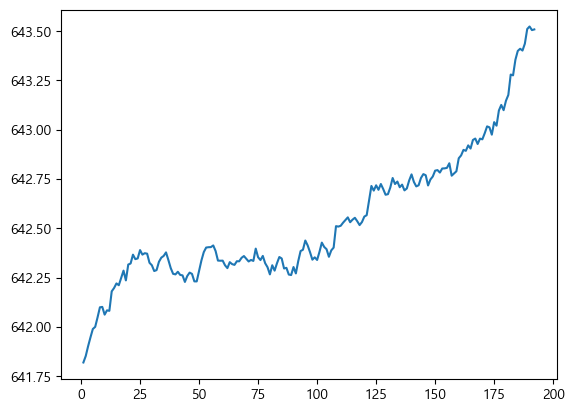

In [233]:
plt.plot(lpf_train.loc[lpf_train['unit']==1, 'cycle'], lpf_train.loc[lpf_train['unit']==1, 'T24'])

- 적절한 파라미터의 low-pass filter 적용

In [118]:
# 테스트셋의 각 유닛별 마지막 시점만 가지고 오기.
# 기존 테스트셋의 마지막 인덱스만 찾기
unit_idx = []
for unit in test1['unit'].unique():
    unit_data = test1[test1['unit'] == unit]
    last_index = unit_data.index[-1]
    unit_idx.append(last_index)

In [119]:
rf_lpf_pred = rf_lpf.predict(X_test_lpf)
rf_lpf_pred = rf_lpf_pred[unit_idx]
rf_lpf_mse = mean_squared_error(y_test, rf_lpf_pred)
rf_lpf_rmse = np.sqrt(rf_lpf_mse)
rf_lpf_mae = np.mean(np.abs(y_test - rf_lpf_pred))
print(f'Low-Pass Filter 적용 시 Random Forest Regressor 성능:')
print(f'MSE: {rf_lpf_mse:.4f}')
print(f'RMSE: {rf_lpf_rmse:.4f}')
print(f'MAE: {rf_lpf_mae:.4f}')

Low-Pass Filter 적용 시 Random Forest Regressor 성능:
MSE: 325.2986
RMSE: 18.0360
MAE: 13.3673


In [ ]:
# low_pass filter 적용 후 각종 스케일링 기법 적용